In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import os
import itertools
import rasterio
from matplotlib import pyplot as plt
import geopandas as gpd
from rasterstats import zonal_stats
from tqdm import tqdm
import xarray as xr
from rasterstats import zonal_stats


In [28]:
enso = pd.read_csv('/home/rgreen/DroughtEDM/Data/ENSO/enso_meiv2_2003_2018.csv')

In [49]:
enso_0310 = enso.loc[enso['Unnamed: 0'].isin(['2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010' ])]

In [62]:
enso_0310

,Unnamed: 0,J,F,M,A,M.1,J.1,J.2,A.1,S,O,N,D
0,2003,0.8,0.6,0.5,-0.1,-0.6,-0.1,0.0,0.0,0.1,0.3,0.3,0.1
1,2004,0.2,0.0,-0.4,-0.2,-0.4,-0.3,0.4,0.7,0.5,0.3,0.5,0.5
2,2005,0.1,0.6,0.8,0.1,0.2,0.2,0.0,0.0,0.0,-0.7,-0.7,-0.7
3,2006,-0.7,-0.5,-0.6,-0.8,-0.4,-0.2,0.1,0.6,0.6,0.7,0.9,0.6
4,2007,0.6,0.4,-0.2,-0.4,-0.4,-0.9,-0.8,-0.9,-1.1,-1.1,-1.1,-1.2
5,2008,-1.1,-1.3,-1.5,-1.1,-1.0,-0.9,-0.9,-1.1,-1.1,-1.1,-1.0,-1.0
6,2009,-1.0,-0.8,-0.9,-0.8,-0.7,-0.1,0.5,0.5,0.4,0.6,1.1,1.0
7,2010,0.9,1.3,1.3,0.5,-0.2,-1.3,-2.4,-2.4,-2.3,-2.2,-2.0,-1.9


In [64]:
enso_listlist = enso_0310.loc[:,enso_0310.columns != 'Unnamed: 0'].values.tolist()

In [65]:
enso_listlist

[[0.8, 0.6, 0.5, -0.1, -0.6, -0.1, 0.0, 0.0, 0.1, 0.3, 0.3, 0.1],
 [0.2, 0.0, -0.4, -0.2, -0.4, -0.3, 0.4, 0.7, 0.5, 0.3, 0.5, 0.5],
 [0.1, 0.6, 0.8, 0.1, 0.2, 0.2, 0.0, 0.0, 0.0, -0.7, -0.7, -0.7],
 [-0.7, -0.5, -0.6, -0.8, -0.4, -0.2, 0.1, 0.6, 0.6, 0.7, 0.9, 0.6],
 [0.6, 0.4, -0.2, -0.4, -0.4, -0.9, -0.8, -0.9, -1.1, -1.1, -1.1, -1.2],
 [-1.1, -1.3, -1.5, -1.1, -1.0, -0.9, -0.9, -1.1, -1.1, -1.1, -1.0, -1.0],
 [-1.0, -0.8, -0.9, -0.8, -0.7, -0.1, 0.5, 0.5, 0.4, 0.6, 1.1, 1.0],
 [0.9, 1.3, 1.3, 0.5, -0.2, -1.3, -2.4, -2.4, -2.3, -2.2, -2.0, -1.9]]

In [66]:
enso_flat_list = [item for sublist in enso_listlist for item in sublist]

In [13]:
enso['ond_avg'] = (enso.O + enso.N + enso.D)/3
enso['mam_avg'] = (enso.M + enso.A + enso['M.1'])/3

In [14]:
enso

,Unnamed: 0,J,F,M,A,M.1,J.1,J.2,A.1,S,O,N,D,ond_avg,mam_avg
0,2003,0.8,0.6,0.5,-0.1,-0.6,-0.1,0.0,0.0,0.1,0.3,0.3,0.1,0.233333,-0.066667
1,2004,0.2,0.0,-0.4,-0.2,-0.4,-0.3,0.4,0.7,0.5,0.3,0.5,0.5,0.433333,-0.333333
2,2005,0.1,0.6,0.8,0.1,0.2,0.2,0.0,0.0,0.0,-0.7,-0.7,-0.7,-0.700000,0.366667
3,2006,-0.7,-0.5,-0.6,-0.8,-0.4,-0.2,0.1,0.6,0.6,0.7,0.9,0.6,0.733333,-0.600000
4,2007,0.6,0.4,-0.2,-0.4,-0.4,-0.9,-0.8,-0.9,-1.1,-1.1,-1.1,-1.2,-1.133333,-0.333333
5,2008,-1.1,-1.3,-1.5,-1.1,-1.0,-0.9,-0.9,-1.1,-1.1,-1.1,-1.0,-1.0,-1.033333,-1.200000
6,2009,-1.0,-0.8,-0.9,-0.8,-0.7,-0.1,0.5,0.5,0.4,0.6,1.1,1.0,0.900000,-0.800000
7,2010,0.9,1.3,1.3,0.5,-0.2,-1.3,-2.4,-2.4,-2.3,-2.2,-2.0,-1.9,-2.033333,0.533333
8,2011,-1.8,-1.6,-1.8,-1.7,-1.3,-1.1,-0.9,-0.9,-1.2,-1.4,-1.2,-1.2,-1.266667,-1.600000
9,2012,-1.1,-0.7,-0.6,-0.4,-0.3,-0.3,0.3,-0.1,-0.3,-0.2,-0.1,-0.1,-0.133333,-0.433333


In [26]:
def simplex_mean(in_dir):
    
    
    simplex_rasters = np.array(sorted(os.listdir(in_dir)))
    tifs = pd.Series(simplex_rasters).str.contains('.tif')
    files = simplex_rasters[tifs]
    
    mean_simplex = []
    
    for filename in files:
            simplex_raster = rasterio.open(in_dir + filename)
            read_raster = simplex_raster.read(1)
            mean_raster = np.nanmean(read_raster)
            mean_simplex.append(mean_raster)
            
    return mean_simplex


In [3]:
mean_simplex_out_cr_ond = simplex_mean('/home/rgreen/DroughtEDM/Data/Seasonal_Simplex/ndvi_ea_simplex_ond_cr_years/')
mean_simplex_out_cr_mam = simplex_mean('/home/rgreen/DroughtEDM/Data/Seasonal_Simplex/ndvi_ea_simplex_mam_cr_years/')

In [27]:
mean_simplex_monthly = simplex_mean('/home/rgreen/DroughtEDM/Data/Seasonal_Simplex/ndvi_ea_simplex_monthly/')

/home/rgreen/miniconda3/envs/edm/lib/python3.7/site-packages/numpy/core/fromnumeric.py:90: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


In [15]:
data_cr_ond = {'Year': list(range(2003, 2019)), 'AvgENSO': enso.ond_avg, 'AvgSimplex': mean_simplex_out_cr_ond}
data_cr_mam = {'Year': list(range(2003, 2019)), 'AvgENSO': enso.mam_avg, 'AvgSimplex': mean_simplex_out_cr_mam}

In [19]:
prediction_skill_enso_cr_ond = pd.DataFrame(data_cr_ond, columns=['Year', 'AvgENSO', 'AvgSimplex'])
prediction_skill_enso_cr_mam = pd.DataFrame(data_cr_mam, columns=['Year', 'AvgENSO', 'AvgSimplex'])

Text(0, 0.5, 'Avg OND Seasonal NDVI Prediction SKill ')

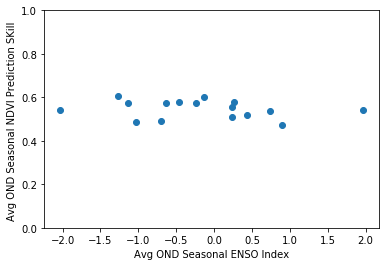

In [74]:
fig = plt.figure()
plt.ylim(0,1)
plt.scatter(prediction_skill_enso_cr_ond.AvgENSO, prediction_skill_enso_cr_ond.AvgSimplex)
plt.xlabel('Avg OND Seasonal ENSO Index')
plt.ylabel('Avg OND Seasonal NDVI Prediction SKill ')

Text(0, 0.5, 'Avg MAM Seasonal NDVI Prediction SKill')

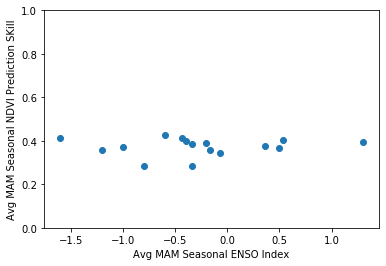

In [75]:
plt.scatter(prediction_skill_enso_cr_mam.AvgENSO, prediction_skill_enso_cr_mam.AvgSimplex)
plt.ylim(0,1)
plt.xlabel('Avg MAM Seasonal ENSO Index')
plt.ylabel('Avg MAM Seasonal NDVI Prediction SKill')

In [59]:
len(enso_flat_list)

192

In [60]:
len(mean_simplex_monthly)

96

In [68]:
data_monthly = {'MonthlyENSO': enso_flat_list, 'MonthlySimplex': mean_simplex_monthly}


In [70]:
prediction_skill_enso_monthly = pd.DataFrame(data_monthly, columns=['MonthlyENSO', 'MonthlySimplex'])

Text(0, 0.5, 'NDVI Monthly Predictive Skill')

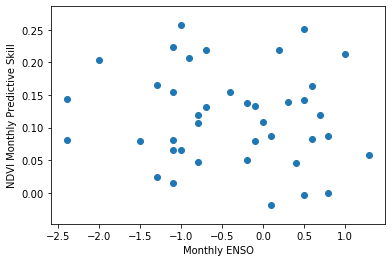

In [73]:
fig = plt.figure()
plt.scatter(prediction_skill_enso_monthly.MonthlyENSO, prediction_skill_enso_monthly.MonthlySimplex)
plt.xlabel('Monthly ENSO')
plt.ylabel('NDVI Monthly Predictive Skill')